# Immigration Data Lake
### Data Engineering Capstone Project

#### Project Summary
The project aims to create a data lake for US immigration data and developing an ETL pipeline to build this data lake using I94 immigration data, airports data, global temperature data and US cities demographics. The raw data residing in various formats is extracted, transformed into a set of facts and dimensiona tables using Spark and loaded onto a S3 bucket for further analytics. This data can be used to study patterns in US immigration, like country of origin of most immigrants, age group, visa type, etc.

The project can be divided into the following steps:
* Step 1: Scope of the project, dataset description and reading data
* Step 2: Exploring and Assessing the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Importing libraries
import configparser
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import types as T
from pyspark.sql.functions import countDistinct, monotonically_increasing_id, count, when, isnan, col, sum
from pyspark.sql.functions import year, month, dayofmonth, weekofyear
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os

### Step 1: Scope of the Project, Data description and reading the data

#### Scope
The scope of this project can be described by the following steps:
1. Use spark and pandas to load the data.
2. Explore, analyze and clean all the datasets:
    - Airports Data
    - US cities demographics
    - World Temperature Data
    - I94 immigration Data
3. Evaluate the data requirements for analysis and design data model.
4. Design and develop the data model as a set of fact and dimensions tables.
5. Develop an ETL pipeline to build the data model on a S3 bucket.
6. Perform tests on data to ensure Data Quality.

Amazon S3 and Apache Spark are utilized to build the project.

#### Describe and Gather Data 
The data used in this project are:
1. I94 Immigration Data: This data comes from the US National Tourism and Trade Office. SAS file. 
    Source: https://travel.trade.gov/research/reports/i94/historical/2016.html
2. World Temperature Data: This dataset came from Kaggle. CSV file. 
    Source: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
3. U.S. City Demographic Data: This data comes from OpenSoft. CSV file. 
    Source: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/
4. Airport Table: This is a simple table of airport codes and their details. CSV file. 
    Source: https://datahub.io/core/airport-codes#data

#### Configuring AWS

In [2]:
config = configparser.ConfigParser()
config.read('dl.cfg')

os.environ['AWS_ACCESS_KEY_ID'] = config['AWS CREDS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = config['AWS CREDS']['AWS_SECRET_ACCESS_KEY']

#### Reading Data

In [3]:
# Reading airport data
airport = pd.read_csv("airport-codes_csv.csv")
print(airport.shape)
airport.head()

(55075, 12)


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [4]:
# Reading US cities demographics data
cities = pd.read_csv("us-cities-demographics.csv", delimiter=";")
print(cities.shape)
cities.head()

(2891, 12)


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [89]:
# Reading Global Temperature Data
temp = pd.read_csv("../../data2/GlobalLandTemperaturesByCity.csv")
print(temp.shape)
temp.head()

(8599212, 7)


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [5]:
# Creating spark object
spark = SparkSession.builder\
.config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11,org.apache.hadoop:hadoop-aws:2.7.2")\
.config("spark.hadoop.fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem") \
.config("spark.hadoop.fs.s3a.access.key", os.environ['AWS_ACCESS_KEY_ID']) \
.config("spark.hadoop.fs.s3a.secret.key", os.environ['AWS_SECRET_ACCESS_KEY']) \
.enableHiveSupport().getOrCreate()

sc = spark.sparkContext
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key",os.environ['AWS_ACCESS_KEY_ID'])
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key",os.environ['AWS_SECRET_ACCESS_KEY'])

In [7]:
# Reading I94 immigration data
months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

for month in months:
    print("Reading month ", month)
    i94 = spark.read.format('com.github.saurfang.sas.spark').load(f"../../data/18-83510-I94-Data-2016/i94_{month}16_sub.sas7bdat")
    i94.write.mode('append').partitionBy("i94mon").parquet("s3a://udacity-srishti-capstone/input/i94.parquet")

Reading month  jan
Reading month  feb
Reading month  mar
Reading month  apr
Reading month  may
Reading month  jun
Reading month  jul
Reading month  aug
Reading month  sep
Reading month  oct
Reading month  nov
Reading month  dec


In [9]:
# Reading the parquet file created
immigration = spark.read.parquet("s3a://udacity-srishti-capstone/input/i94.parquet")
print((immigration.count(), len(immigration.columns)))
immigration.show()

(42099117, 28)
+---------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+-------------+-----+--------+------+
|    cicid| i94yr|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|       admnum|fltno|visatype|i94mon|
+---------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+-------------+-----+--------+------+
|5680949.0|2016.0| 117.0| 117.0|    NYC|20659.0|    1.0|     NY|   null|  30.0|    3.0|  1.0|20160724|     NPL| null|      G|   null|   null|   null| 1986.0|     D/S|     F|  null|     IG|2.947450085E9| 3940|      F1|   7.0|
|5680950.0|2016.0| 245.0| 245.0|    DET|20659.0|    1.0|     IL|20679.0|  46.0|    2.

### Step 2: Exploring and Assessing the Data
#### Explore the Data
1. Visualize the data quality issues.
2. Identify data quality issues, like missing values and duplicate data.

#### Cleaning Steps
1. Delete columns with more than 30% missing values.
2. Delete rows having missing values where columns did not have more than 30% of the data as missing or if the column was necessary for the table.
3. Remove rows containing duplicate data.

#### Visualizing missing values

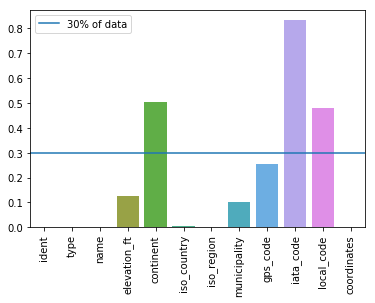

In [9]:
# Checking for null values in airport data
airport.isna().sum()
graph = sns.barplot(x = list(airport.columns.values), y = airport.isna().sum()/airport.shape[0])
graph.axhline(0.3, label = "30% of data")
graph.set_xticklabels(graph.get_xticklabels(), rotation = 90)
plt.legend()

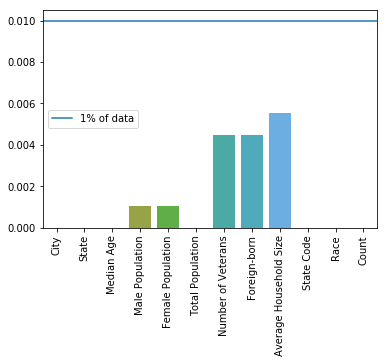

In [10]:
# Checking for null values in US cities demographics
cities.isna().sum()
graph = sns.barplot(x = list(cities.columns.values), y = cities.isna().sum()/cities.shape[0])
graph.axhline(0.01, label = "1% of data")
graph.set_xticklabels(graph.get_xticklabels(), rotation = 90)
plt.legend()

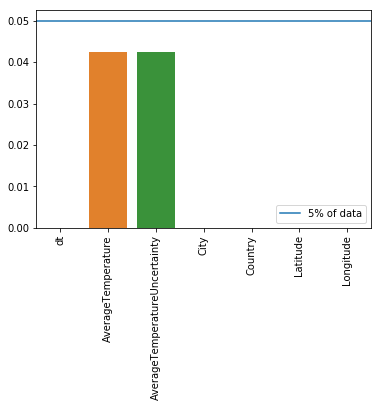

In [11]:
# Checking for null values in world temperature data
temp.isna().sum()
graph = sns.barplot(x = list(temp.columns.values), y = temp.isna().sum()/temp.shape[0])
graph.axhline(0.05, label = "5% of data")
graph.set_xticklabels(graph.get_xticklabels(), rotation = 90)
plt.legend()

In [12]:
# Checking for null values in immigration data
i94nulls = [immigration.filter(immigration[col].isNull()).count() for col in immigration.columns]

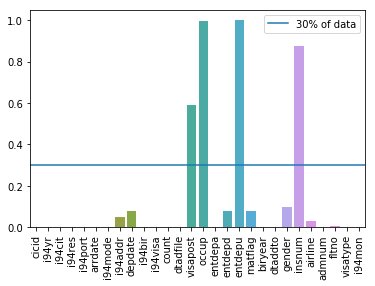

In [13]:
graph = sns.barplot(x = list(immigration.columns), y = np.array(i94nulls)/immigration.count())
graph.axhline(0.3, label = "30% of data")
graph.set_xticklabels(graph.get_xticklabels(), rotation = 90)
plt.legend()

#### Handling missing values

In [14]:
# Removing continent and local_code features from airports dataframe,
# and removing rows where IATA code is Nan as it uniquely identifies each row
airport.drop(['continent', 'local_code'], axis = 1, inplace = True)
airport.dropna(inplace = True)
print(airport.shape)
airport.head()

(7561, 10)


,ident,type,name,elevation_ft,iso_country,iso_region,municipality,gps_code,iata_code,coordinates
223,03N,small_airport,Utirik Airport,4.0,MH,MH-UTI,Utirik Island,K03N,UTK,"169.852005, 11.222"
440,07FA,small_airport,Ocean Reef Club Airport,8.0,US,US-FL,Key Largo,07FA,OCA,"-80.274803161621, 25.325399398804"
673,0CO2,small_airport,Crested Butte Airpark,8980.0,US,US-CO,Crested Butte,0CO2,CSE,"-106.928341, 38.851918"
1088,0TE7,small_airport,LBJ Ranch Airport,1515.0,US,US-TX,Johnson City,0TE7,JCY,"-98.62249755859999, 30.251800537100003"
1402,13MA,small_airport,Metropolitan Airport,418.0,US,US-MA,Palmer,13MA,PMX,"-72.31140136719999, 42.223300933800004"


In [15]:
# Removing rows with Nans in cities demographics dataframe
cities.dropna(inplace = True)
print(cities.shape)
cities.head()

(2875, 12)


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [16]:
# Removing rows with Nans in world temperature dataframe
temp.dropna(inplace = True)
print(temp.shape)
temp.head()

(8235082, 7)


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


In [17]:
# Removing continent and local_code features from airports dataframe,
# and removing rows where IATA code is Nan as it uniquely identifies each row
immigration = immigration.drop('visapost', 'occup', 'entdepu', 'insnum')
immigration = immigration.dropna()
print(immigration.count())
immigration.show()

31103104
+---------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+-------+-------+-------+-------+--------+------+-------+-------------+-----+--------+------+
|    cicid| i94yr|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|entdepa|entdepd|matflag|biryear| dtaddto|gender|airline|       admnum|fltno|visatype|i94mon|
+---------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+-------+-------+-------+-------+--------+------+-------+-------------+-----+--------+------+
|5680950.0|2016.0| 245.0| 245.0|    DET|20659.0|    1.0|     IL|20679.0|  46.0|    2.0|  1.0|20160813|      G|      O|      M| 1970.0|01232017|     M|     DL|2.947451085E9|  188|      B2|   7.0|
|5680953.0|2016.0| 245.0| 245.0|    SEA|20659.0|    1.0|     WA|20670.0|  36.0|    2.0|  1.0|20160804|      G|      O|      M| 1980.0|01232017|     F|     OZ|2.947454785E9|  272|      B2|   7.0|
|5680954.0|2016.

#### Handling data duplication

Removing duplicate rows from all the data sets, if any.

In [20]:
# Dropping duplicates from all the datasets
airport.drop_duplicates(subset = ['iata_code'])
print(airport.shape)
cities.drop_duplicates(subset = ['City', 'State', 'Race'])
print(cities.shape)
temp.drop_duplicates()
print(temp.shape)
immigration.dropDuplicates()
print(immigration.count())

(7561, 10)
(2875, 12)
(8235082, 7)
31103104


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The conceptual data model can be seen below:
<img src="images/dend.jpg">

This data model was based on the star schema design with i94 data as the fact table and various dimension tables. This model offers efficient analysis of data for the US immigration patterns and provide essential dimension tables for more detailed information.
The immigrant dimension table provides all the personal details for an immigrant like gender, birth year, country of origin, etc. The airport dimension table can be utilized when more detail about an airport is needed like, city of the airport, its type, airport name, etc. US demographics dimension table can be utilized to gather information about demographics in all the cities of a particular state, for example female population, ethnicities, total population, etc., which can help in determining if there's a demographic pattern in states with higher number of immigrants. The arrival and departure dimension tables provide date, year, month and week of the arrival and departure dates.

#### 3.2 Mapping Out Data Pipelines
The steps necessary to pipeline the data into the chosen data model are:
1. Load the spark dataframe for airports using the cleaned dataset.
2. Create the Airport dimension table with IATA code as the primary key from airport dataframe, which can be linked to the I94 port of the I94 fact table.
3. Load the spark dataframe for US demographics using the cleaned dataset.
4. Create the US demographics dimension table with a Unique ID for each row from cities data frame, and it can be linked to the State code of the I94 fact table.
5. Load the immigration data frame.
6. Create the I94 fact table with all the essential fetures and cicid as the primary key from immigration dataframe.
7. Create the Immigrants dimension table with cicid as the primary key from immigration data frame, and it can be linked to the cicid column of the I94 fact table.
8. Create the arrival date dimension table with arrival date as the primary key and it lists out all the features of the date. It is created using the immigration data frame and can be linked to the arrdate column of the i94 fact table.
9. Create the departure date dimension table with departure date as the primary key and it lists out all the features of the date. It is created using the immigration data frame and can be linked to the depdate column of the i94 fact table.

In [21]:
# Not using count in immigration data since it has only one value '1' for all the records
immigration.groupBy("count").count().show()

# Hence this column is not included in the data lake

+-----+--------+
|count|   count|
+-----+--------+
|  1.0|31103104|
+-----+--------+



### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [22]:
# Path to output directory
OUTPUT_DATA = "s3a://udacity-srishti-capstone/"

In [25]:
def process_airport_table(spark, airport_df):
    """
    Description: This function processes the airport dataframe and creates
                 the airport dimension table. It also creates the final parquet data
                 on the S3 bucket to be used for further analytics.
    Parameters:
            @input: spark - Spark Session, airport_df - Airport dataframe
            @output: airport_table - Final airport dimension table
    """
    airport_spark_df = spark.createDataFrame(airport_df)
    airport_spark_df.createOrReplaceTempView("airport_spark_table")
    airport_table = spark.sql("""SELECT
                                    ident AS identifier,
                                    type,
                                    name,
                                    elevation_ft,
                                    iso_country,
                                    iso_region,
                                    municipality,
                                    gps_code,
                                    iata_code,
                                    SPLIT(coordinates,',')[0]  AS coordinatex,
                                    SPLIT(coordinates,',')[1]  AS coordinatey
                                    FROM airport_spark_table
                              """)
    airport_table = airport_table.dropDuplicates(['iata_code'])
    airport_table.write.mode('overwrite').partitionBy('iata_code').parquet(OUTPUT_DATA + "airport.parquet")
    return airport_table

In [26]:
# Creating airport table and parquet file
airport_table = process_airport_table(spark, airport)
airport_table.printSchema()
airport_table.show(10)

root
 |-- identifier: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: double (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- coordinatex: string (nullable = true)
 |-- coordinatey: string (nullable = true)

+----------+--------------+--------------------+------------+-----------+----------+--------------------+--------+---------+------------------+--------------------+
|identifier|          type|                name|elevation_ft|iso_country|iso_region|        municipality|gps_code|iata_code|       coordinatex|         coordinatey|
+----------+--------------+--------------------+------------+-----------+----------+--------------------+--------+---------+------------------+--------------------+
|      VAAK|medium_airport|       Akola Airpo

In [29]:
def process_usdemographics_table(spark, demographs_df):
    """
    Description: This function processes the demographics dataframe and creates
                 the US demographics dimension table. It also creates the final parquet data
                 on the S3 bucket to be used for further analytics.
    Parameters:
            @input: spark - Spark Session, demographs_df - Demographics dataframe
            @output: demographics_table - Final demographics dimension table
    """
    demographs_spark_df = spark.createDataFrame(demographs_df)
    demographs_spark_df.createOrReplaceTempView("cities_spark_table")
    demographics_table = spark.sql("""SELECT
                                    monotonically_increasing_id() AS demo_id,
                                    City AS city,
                                    State AS state,
                                    Race AS race,
                                    'State Code' AS state_code,
                                    'Median Age' AS age_median,
                                    'Male Population' AS male,
                                    'Female Population' AS female,
                                    'Total Population' AS total_population,
                                    'Number of Veterans' AS veterans,
                                    'Foreign-born' AS foreign_borns,
                                    'Average Household Size' AS household_size,
                                    Count AS count
                                    FROM cities_spark_table
                              """)
    demographics_table = demographics_table.dropDuplicates(['city', 'state', 'race'])
    demographics_table.write.mode('overwrite').partitionBy('city').parquet(OUTPUT_DATA + "demographics.parquet")
    return demographics_table

In [30]:
# Creating demographics table and parquet file
demographics_table = process_usdemographics_table(spark, cities)
demographics_table.printSchema()
demographics_table.show(10)

root
 |-- demo_id: long (nullable = false)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- race: string (nullable = true)
 |-- state_code: string (nullable = false)
 |-- age_median: string (nullable = false)
 |-- male: string (nullable = false)
 |-- female: string (nullable = false)
 |-- total_population: string (nullable = false)
 |-- veterans: string (nullable = false)
 |-- foreign_borns: string (nullable = false)
 |-- household_size: string (nullable = false)
 |-- count: long (nullable = true)

+-------+----------------+----------+--------------------+----------+----------+---------------+-----------------+----------------+------------------+-------------+--------------------+------+
|demo_id|            city|     state|                race|state_code|age_median|           male|           female|total_population|          veterans|foreign_borns|      household_size| count|
+-------+----------------+----------+--------------------+----------+----------+-

In [52]:
def process_i94_table(spark, i94_df):
    """
    Description: This function processes the i94 dataframe and creates
                 the I94 fact table, immigrant, arrival date, departure date dimension tables.
                 It also creates the final parquet data
                 on the S3 bucket to be used for further analytics.
    Parameters:
            @input: spark - Spark Session, i94_df - Demographics dataframe
            @output: [i94_fact_table, immigrant_table, arrival_table, departure_table]
                     Final fact and dimension tables
    """
    # Datetime conversion
    udf_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    i94_df.createOrReplaceTempView("i94_spark_table")
    
    #I94 Fact Table
    i94_fact_table = spark.sql("""SELECT
                                    cicid,
                                    i94yr,
                                    i94port,
                                    i94mode,
                                    i94addr,
                                    depdate,
                                    i94visa,
                                    arrdate,
                                    dtadfile,
                                    entdepa,
                                    entdepd,
                                    matflag,
                                    admnum,
                                    i94mon
                                    FROM i94_spark_table
                              """)
    i94_fact_table = i94_fact_table.withColumn("arrdate", udf_datetime(i94_df.arrdate))
    i94_fact_table = i94_fact_table.withColumn("depdate", udf_datetime(i94_df.depdate))
    i94_fact_table = i94_fact_table.dropDuplicates(['cicid'])
    i94_fact_table.write.mode('overwrite').partitionBy('i94mon').parquet(OUTPUT_DATA + "i94fact.parquet")
    
    # Immigrant Table
    immigrant_table = spark.sql("""SELECT
                                    cicid,
                                    i94cit,
                                    i94res,
                                    i94bir,
                                    biryear,
                                    dtaddto,
                                    gender,
                                    airline,
                                    fltno,
                                    visatype
                                    FROM i94_spark_table
                              """)
    immigrant_table = immigrant_table.dropDuplicates(['cicid'])
    immigrant_table.write.mode('overwrite').partitionBy('i94res').parquet(OUTPUT_DATA + "immigrant.parquet")
    
    # Arrival Date Table
    arrival_table = i94_df.select(['arrdate']).withColumn("arrdate", udf_datetime(i94_df.arrdate))
    arrival_table = arrival_table.withColumn('day', dayofmonth('arrdate'))
    arrival_table = arrival_table.withColumn('week', weekofyear('arrdate'))
    arrival_table = arrival_table.withColumn('month', month('arrdate'))
    arrival_table = arrival_table.withColumn('year', year('arrdate'))
    
    arrival_table = arrival_table.dropDuplicates()
    arrival_table.write.mode('overwrite').partitionBy('year').parquet(OUTPUT_DATA + "arrival.parquet")
    
    # Departure Date Table
    departure_table = i94_df.select(['depdate']).withColumn("depdate", udf_datetime(i94_df.depdate))
    departure_table = departure_table.withColumn('day', dayofmonth('depdate'))
    departure_table = departure_table.withColumn('week', weekofyear('depdate'))
    departure_table = departure_table.withColumn('month', month('depdate'))
    departure_table = departure_table.withColumn('year', year('depdate'))
    
    departure_table = departure_table.dropDuplicates()
    departure_table.write.mode('overwrite').partitionBy('year').parquet(OUTPUT_DATA + "departure.parquet")
    
    return [i94_fact_table, immigrant_table, arrival_table, departure_table]

In [53]:
# Creating i94 fact table and parquet file
i94_fact_table = process_i94_table(spark, immigration)[0]
i94_fact_table.printSchema()
i94_fact_table.show(5)

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: string (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- arrdate: string (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- i94mon: double (nullable = true)

+-----+------+-------+-------+-------+----------+-------+----------+--------+-------+-------+-------+---------------+------+
|cicid| i94yr|i94port|i94mode|i94addr|   depdate|i94visa|   arrdate|dtadfile|entdepa|entdepd|matflag|         admnum|i94mon|
+-----+------+-------+-------+-------+----------+-------+----------+--------+-------+-------+-------+---------------+------+
|299.0|2016.0|    LOS|    1.0|     AL|2016-05-08|    2.0|2016-05-01|20160501| 

In [54]:
# Creating immigrants table and parquet file
immigrant_table = process_i94_table(spark, immigration)[1]
immigrant_table.printSchema()
immigrant_table.show(5)

root
 |-- cicid: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)

+-----+------+------+------+-------+--------+------+-------+-----+--------+
|cicid|i94cit|i94res|i94bir|biryear| dtaddto|gender|airline|fltno|visatype|
+-----+------+------+------+-------+--------+------+-------+-----+--------+
|299.0| 103.0| 103.0|  20.0| 1996.0|07292016|     F|     DY|07095|      WT|
|305.0| 111.0| 111.0|  42.0| 1974.0|01292017|     M|     AF|   90|      WT|
|496.0| 103.0| 103.0|  17.0| 1999.0|09282016|     M|     LH|00412|      WT|
|558.0| 110.0| 110.0|  65.0| 1951.0|09282016|     F|     AY|00009|      WT|
|596.0| 504.0| 504.0|  44.0| 1972.0|04302017|     M|     AA|  981|      B2|
+--

In [55]:
# Creating arrival date table and parquet file
arrival_table = process_i94_table(spark, immigration)[2]
arrival_table.printSchema()
arrival_table.show(5)

root
 |-- arrdate: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)

+----------+---+----+-----+----+
|   arrdate|day|week|month|year|
+----------+---+----+-----+----+
|2016-07-15| 15|  28|    7|2016|
|2016-12-07|  7|  49|   12|2016|
|2016-07-13| 13|  28|    7|2016|
|2016-09-30| 30|  39|    9|2016|
|2016-01-08|  8|   1|    1|2016|
+----------+---+----+-----+----+
only showing top 5 rows



In [56]:
# Creating departure date table and parquet file
departure_table = process_i94_table(spark, immigration)[3]
departure_table.printSchema()
departure_table.show(5)

root
 |-- depdate: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)

+----------+---+----+-----+----+
|   depdate|day|week|month|year|
+----------+---+----+-----+----+
|2016-07-15| 15|  28|    7|2016|
|2016-12-07|  7|  49|   12|2016|
|2017-03-31| 31|  13|    3|2017|
|2016-09-30| 30|  39|    9|2016|
|2016-07-13| 13|  28|    7|2016|
+----------+---+----+-----+----+
only showing top 5 rows



#### 4.2 Data Quality Checks
The data quality checks to be performed to ensure the pipeline runs as expected are:
1. Checking that there are no duplicates in the primary key of the table.
2. The primary/unique key does not contain null values.
3. Foreign keys can be mapped to the dimension tables.
4. Count the number of rows in the fact and dimension tables and check if that matches with the initial data to check the completeness of data.
5. Unit tests can be written to test the functionality of the code.

A few basic checks performed on the data can be seen below.

In [69]:
# Check for null values in primary key of the fact table
i94_fact_table.select([count(when(isnan('cicid') | col('cicid').isNull(), 'cicid')).alias('cicid')]).show()

+-----+
|cicid|
+-----+
|    0|
+-----+



In [70]:
# Check for null values in primary key of the airport dimension table
airport_table.select([count(when(isnan('iata_code') | col('iata_code').isNull(), 'iata_code')).alias('iata_code')]).show()

+---------+
|iata_code|
+---------+
|        0|
+---------+



In [76]:
# Checking for duplicate values in primary key
airport_table.groupBy(['iata_code']).count().where(col('count') > 1).select(sum('count').alias('Duplicate IATA Code')).show()

+-------------------+
|Duplicate IATA Code|
+-------------------+
|               null|
+-------------------+



In [82]:
# Checking number of rows in dimension tables
print("Number of rows check passed for demographics dimension table: ", demographics_table.count() == cities.shape[0])

Number of rows check passed for demographics dimension table:  True


#### 4.3 Data dictionary 
The data dictionary for the data model created can be seen below:

##### Airports Table
| Column Name   | Description                                               |
| ------------- | --------------------------------------------------------- |
| iata\_code    | 3 letter code for International Air Transport Association |
| identifier    | Identifier                                                |
| type          | Airport Type                                              |
| name          | Airport Name                                              |
| elevation\_ft | Elevation of the airport in feets                         |
| iso\_country  | Country                                                   |
| iso\_region   | Region                                                    |
| municipality  | Municipality                                              |
| gps\_code     | GPS code of the airport                                   |
| coordinatex   | x coordinate of the airport                               |
| coordinatey   | y coordinate of the airport                               |

##### US Demographics Table
| Column Name       | Description                            |
| ----------------- | -------------------------------------- |
| demo\_id          | Unique identifier for each row         |
| city              | City                                   |
| state             | State                                  |
| race              | Race                                   |
| state\_code       | 3 letter code for state                |
| age\_median       | Median age of the population           |
|  male             | Male population                        |
| female            | Female population                      |
| total\_population | Total population                       |
| veterans          | Number of veterans                     |
| foreign\_borns    | Number of Foreign borns in the region  |
| household\_size   | Household size                         |
| count             | Number of people in this configuration |

##### I94 Fact table
| Column Name | Description                                         |
| ----------- | --------------------------------------------------- |
| cicid       | Unique identifier                                   |
| i94yr       | 4 digit year                                        |
| i94port     | 3 character port of entry                           |
| arrdate     | Arrival date                                        |
| i94mode     | Mode of transportation                              |
| i94addr     | State code                                          |
| depdate     | Departure date                                      |
| i94visa     | Visa code with 3 categories                         |
| dtadfile    | Date added to I-94 Files                            |
| entdepa     | Arrival Flag - admitted or paroled into the U.S.    |
| entdepd     | Departure Flag - Departed, lost I-94 or is deceased |
| matflag     | Match flag - Match of arrival and departure records |
| admnum      | Admission number                                    |
| i94month    | Month                                               |

##### Immigrant Data
| Column Name | Description                                                                        |
| ----------- | ---------------------------------------------------------------------------------- |
| cicid       | Unique identifier                                                                  |
| i94cit      | Country of origin                                                                  |
| i94res      | Country of residence                                                               |
| i94bir      | Age of immigrant in years                                                          |
| biryear     | Birth year                                                                         |
| dtaddto     |  Date to which admitted to U.S. (allowed to stay until)                            |
| gender      | Gender                                                                             |
| airline     | Airline used to travel                                                             |
| fltno       | Flight number of the aircraft                                                      |
| visa\_type  | Class of admission legally admitting the non-immigrant to temporarily stay in U.S. |

##### Arrival date
| Column Name | Description  |
| ----------- | ------------ |
| arrdate     | Arrival Date |
| date        | Date         |
| month       | Month        |
| year        | Year         |
| week        | Week         |

##### Departure date
| Column Name | Description    |
| ----------- | -------------- |
| deptdate    | Departure date |
| date        | Date           |
| month       | Month          |
| year        | Year           |
| week        | Week           |

#### Step 5: Project Write Up
* The rationale for the choice of tools and technologies for the project.
    - Given the amount of data used in this project, i.e. millions of records of data, using Spark and Amazon S3 seem approprite to handle this efficiently and in a cost-effective way. Amazon S3 can handle large amount of data and Spark can be used to perform operations on this data.
* How often the data should be updated and why.
    - The data should be updated monthly as the immigration records are updated every month. Hence updating the data monthly would suffice in updating the fact table as well as required dimension tables.
* A description of the approach for the following scenarios:
 * The data was increased by 100x.
     - Amazon S3 and Spark can still be used to handle the data but the script can be run on an EMR cluster with more number of nodes. Moreover, data used for reading might also be required to move to an S3 bucket and EMR cluster can read it from there. The higher number of nodes can help in processing the larger amount of data more efficiently.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     - The data pipeline can be built on Airflow with daily schedule interval. The pipeline created as a DAG in the airflow can be automated to update daily, and thus won't require manual execution of the pipeline. Hence, it can be used to populate the dashboard on a daily basis.
 * The database needed to be accessed by 100+ people.
     - Using S3 bucket should still work in this scenario, but we can consider using AWS Redshift or EMR HDFS for better performance. As we know, redshift has massively parallel architecture and is horizontally scalable, it can be utilized when database is required to be accessed by 100+ people. The data can be distributed based on business needs accross various nodes to increase the performance. Moreover, redshift has automatic optimization feature, which automatically adjusts data layout, distribution keys, and query plans to provide optimal performance for a given workload. Amazon Redshift's scability can boost throughput to support increases in concurrent users, and scales linearly for simple and mixed workloads. Hence, this seems to be an appropriate choice when more people need to access database. Elastic load balancers can also be used to distribute requests over multiple servers.